* 얼굴 각각의 위치를 찾아내는 기술 = landmark, alignment => 더 큰 의미론 keypoint detection

In [136]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

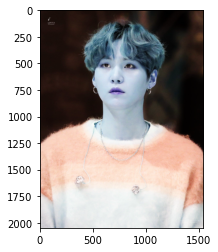

In [137]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image2.png'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

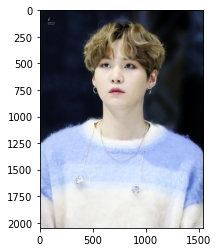

In [138]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### cv2.imread
cv2.imread(fileName, flag)    
**flag**    
* 1 : cv2.IMREAD_COLOR => 이미지를 Color로읽어들인다. 투명한 부분은 무시가 된다.
* 0 : cv2.IMREAD_GRAYSCALE => 이미지를 GrayColor로읽어들인다.
* -1 : cv2.IMREAD_UNCHANGED => 이미지를 alpha channel까지 포함하여 읽어들인다.


https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html

## 얼굴 인식
https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c

1. 모든 얼굴 찾기(face detection) - HOG를 이용
    - 얼굴을 먼저 흑백으로 바꾼다.
    - 모든 픽셀을 화살표로 바꾸는데 이러한 화살표들을 그래디언트라고 부른다.    
    (그래디언트를 사용하는 이유 : 정말 어두운 이미지와 정말 밝은 이미지에 대해 동일하게 표현이 가능하다, 인접한 픽셀 사이 색상변화율 자체를 반영시키기 위해서)
    - 만들어진 HOG이미지의 패턴과 가장 유사해보이는 부분의 이미지를 찾는다.
2. 얼굴의 위치 교정과 투영 : 얼굴이 다른 방향을 볼 수도 있으므로 필요한 과정이다.
    - face landmark estimation 알고리즘을 사용한다.
    - 모든 얼굴에 존재하는 특정포인트(랜드마크)를 찾아낸다.
    - 만들어진 랜드마크들을 최대한 가운데로 올 수 있도록 회전과크기를 조절한다.
3. 얼굴 인코딩
    - deep convolutional neural network를 훈련시키는데 사진에서 객체를 인식하도록 훈련시키는 것이 아닌 각 얼굴에 서 나온 측정값을 생성하도록 훈련시킨다.
4. 인코딩에서 사람의 이름 찾기   
    - 기계 학습 분류 알고리즘을 이용해 분류기를 사용해 이미지를 분류한다.


In [139]:
import dlib
detector_hog = dlib.get_frontal_face_detector() # 박스의 기본 크기는 어느정도일까??

In [140]:
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")
print(dlib_rects)

🌫🛸
rectangles[[(502, 400) (964, 862)]]


### detector_hog(imange, image_pyramids)
**Image Pyramids**  
동일한 이미지의 서로 다른 사이즈의 set    
다양한 사이즈에서 데이터를 찾기위해서 사용.   

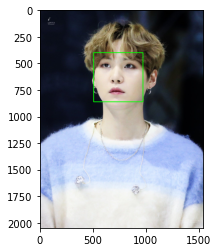

In [141]:
import matplotlib.patches as patches
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 5, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### Object keypoint estimation 알고리즘
객체 내부의 점을 찾는 기술

In [142]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [143]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

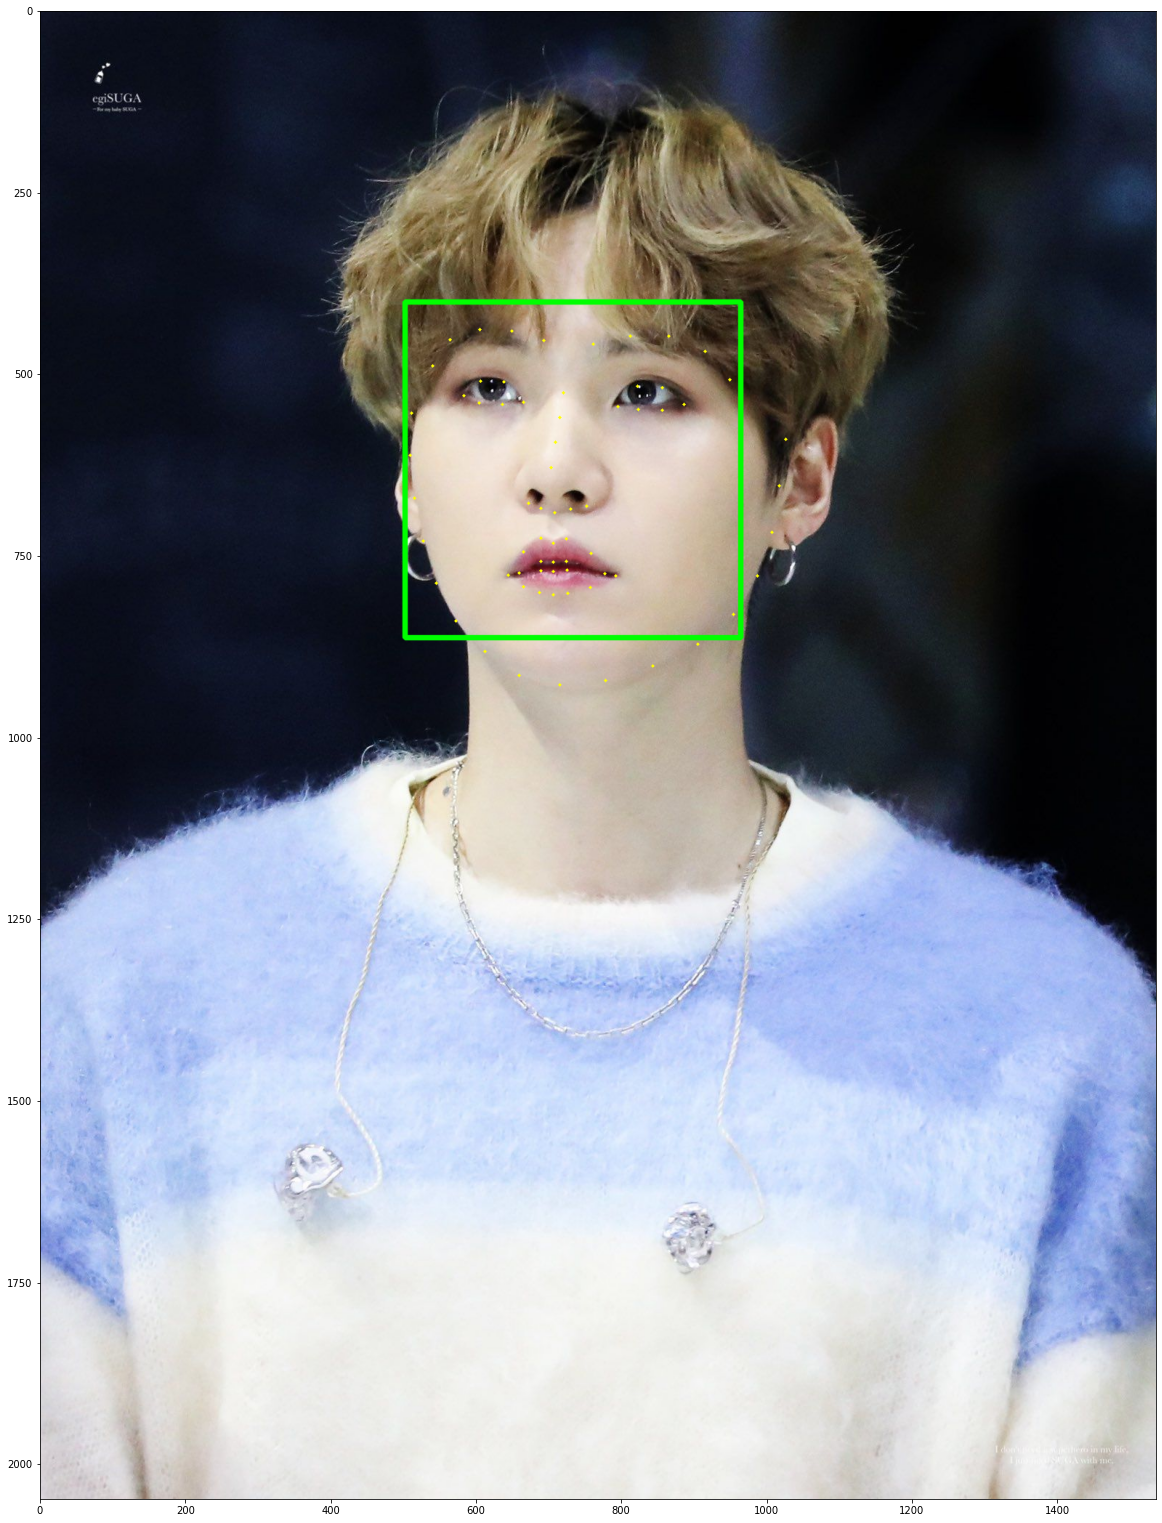

In [144]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,30))
plt.imshow(img_show_rgb)
plt.show()

In [146]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(703, 628)
(x,y) : (703,397)
(w,h) : (463,463)


In [147]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(463, 463, 3)


In [148]:
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (472,-66)


In [149]:
# 음수이면 frame 밖이므로 삭제해줘야한다.
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(397, 463, 3)


In [150]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (472,0)


In [151]:
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

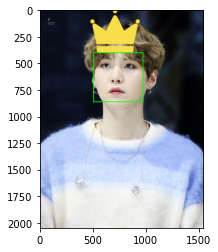

In [152]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

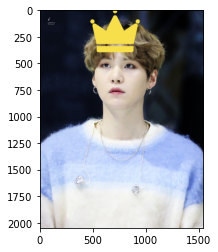

In [153]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()